In [121]:
import numpy as np
import tensorflow as tf

import keras

from tensorflow.keras import layers, Model
# from tensorflow.keras import datasets

from tensorflow.keras.losses import MeanSquaredError, binary_crossentropy
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics

import matplotlib.pyplot as plt

In [122]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data Load and Data Split

In [123]:
relative_dataset_path = './data/'

In [124]:
from pickle import load
from pandas import DataFrame

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = load(fo, encoding='latin1')
    return dict


def read_data(filename):
    data = unpickle(f"{relative_dataset_path}{filename}")
    df = DataFrame(list(data.items()), columns=["Keys", "Values"])
    return data, df

data1, df1 = read_data("data_batch_1")
data2, df2 = read_data("data_batch_2")
data3, df3 = read_data("data_batch_3")
data4, df4 = read_data("data_batch_4")
data5, df5 = read_data("data_batch_5")

test_data, test_df = read_data("test_batch")

# Combine data
x_train = np.concatenate([data1["data"], data2["data"], data3["data"], data4["data"], data5["data"]], axis=0)
y_train = np.concatenate([data1["labels"], data2["labels"], data3["labels"], data4["labels"], data5["labels"]], axis=0)

print("Combined Data Shape:", x_train.shape)
print("Combined Labels Length:", len(y_train))

x_test = test_data["data"]
y_test = test_data["labels"]

print("Test Data Shape: ", x_test.shape)
print("Test Data Labels Length: ", len(y_test))

Combined Data Shape: (50000, 3072)
Combined Labels Length: 50000
Test Data Shape:  (10000, 3072)
Test Data Labels Length:  10000


In [125]:
x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
print("Reshaped Training Data Shape:", x_train.shape)

# Reshape test data
x_test = x_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
print("Reshaped Test Data Shape:", x_test.shape)

Reshaped Training Data Shape: (50000, 32, 32, 3)
Reshaped Test Data Shape: (10000, 32, 32, 3)


## before normalization

In [126]:
x_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

## after normalization

In [127]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train[0]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

In [128]:
latent_dim = 100
image_shape = x_train[0].shape
print(image_shape)

(32, 32, 3)


In [129]:
mse_loss = MeanSquaredError()

In [130]:
class VAE(keras.Model):
    def __init__(self, latent_dim, image_shape, beta):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.image_shape = image_shape
        self.beta = beta

        # encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=image_shape, name="Encoder_Input_Layer"),

            # layers.BatchNormalization(name="Encoder_BatchNorm_1"),
            layers.Conv2D(32, 3, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_2"),
            # layers.BatchNormalization(name="Encoder_BatchNorm_2"),

            # layers.BatchNormalization(name="Encoder_BatchNorm_3"),
            layers.Conv2D(64, 3, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_4"),
            # layers.BatchNormalization(name="Encoder_BatchNorm_4"),

            # layers.BatchNormalization(name="Encoder_BatchNorm_5"),
            layers.Conv2D(128, 3, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_6"),
            # layers.BatchNormalization(name="Encoder_BatchNorm_6"),

            layers.Flatten(name="Encoder_Flatten"),
            # layers.Dense(512,  name="Encoder_Dense_1"),
        ])
        
        # reparameterization/sampling layer 
        self.z_mean = layers.Dense(latent_dim, name="z_mean")
        self.z_log_var = layers.Dense(latent_dim, name="z_log_var")
        
        # decoder
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(8*8*64, activation='relu'),
            layers.Reshape((8, 8, 64)),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='sigmoid'),
        ])
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
     
    # Build the encoder
    def encode(self, data):
        x = self.encoder(data)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        return z_mean, z_log_var
    
    # Build the reparameterization/sampling layer 
    def reparameterization(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z =  z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z
    
    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decode(z)
        return x_recon, mean, logvar
    
    def decode(self, data):
        return self.decoder(data)
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def recon_loss(self, data, reconstruction):
        return tf.reduce_mean(binary_crossentropy(data, reconstruction))

    def kl_divergence(self, Z_logvar, Z_mu):
        kl = -0.5 * tf.reduce_mean(1 + Z_logvar - Z_mu**2 - tf.math.exp(Z_logvar))
        return self.beta * kl

    def train_step(self, data):
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encode(data)
            z = self.reparameterization(z_mean, z_log_var)      
            reconstruction = self.decode(z)

            reconstruction_loss = self.recon_loss(data, reconstruction)
            kl_loss = self.kl_divergence(z_log_var, z_mean)
            
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [131]:
vae = VAE(latent_dim, image_shape, 0.2)
vae.decoder.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 32, 32, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 3)        867       
 ranspose)                                                       
                                                     

In [132]:
vae.encoder.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_Conv2D_2 (Conv2D)   (None, 16, 16, 32)        896       
                                                                 
 Encoder_Conv2D_4 (Conv2D)   (None, 8, 8, 64)          18496     
                                                                 
 Encoder_Conv2D_6 (Conv2D)   (None, 4, 4, 128)         73856     
                                                                 
 Encoder_Flatten (Flatten)   (None, 2048)              0         
                                                                 
Total params: 93,248
Trainable params: 93,248
Non-trainable params: 0
_________________________________________________________________


In [133]:

early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=150, batch_size=128, callbacks=[early_stopping])

Epoch 1/150
391/391 [==============================] - 5s 12ms/step - loss: 0.6724 - reconstruction_loss: 0.6456 - kl_loss: 0.0110
Epoch 2/150
391/391 [==============================] - 4s 11ms/step - loss: 0.6345 - reconstruction_loss: 0.6155 - kl_loss: 0.0169
Epoch 3/150
391/391 [==============================] - 4s 11ms/step - loss: 0.6293 - reconstruction_loss: 0.6112 - kl_loss: 0.0181
Epoch 4/150
391/391 [==============================] - 4s 11ms/step - loss: 0.6287 - reconstruction_loss: 0.6097 - kl_loss: 0.0187
Epoch 5/150
391/391 [==============================] - 5s 12ms/step - loss: 0.6275 - reconstruction_loss: 0.6086 - kl_loss: 0.0191
Epoch 6/150
391/391 [==============================] - 4s 11ms/step - loss: 0.6274 - reconstruction_loss: 0.6080 - kl_loss: 0.0194
Epoch 7/150
391/391 [==============================] - 4s 11ms/step - loss: 0.6269 - reconstruction_loss: 0.6074 - kl_loss: 0.0194
Epoch 8/150
391/391 [==============================] - 4s 11ms/step - loss: 0.6269 

In [134]:
# from datetime import datetime
# timestamp = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
# vae.save("vae_" + timestamp + ".h5")

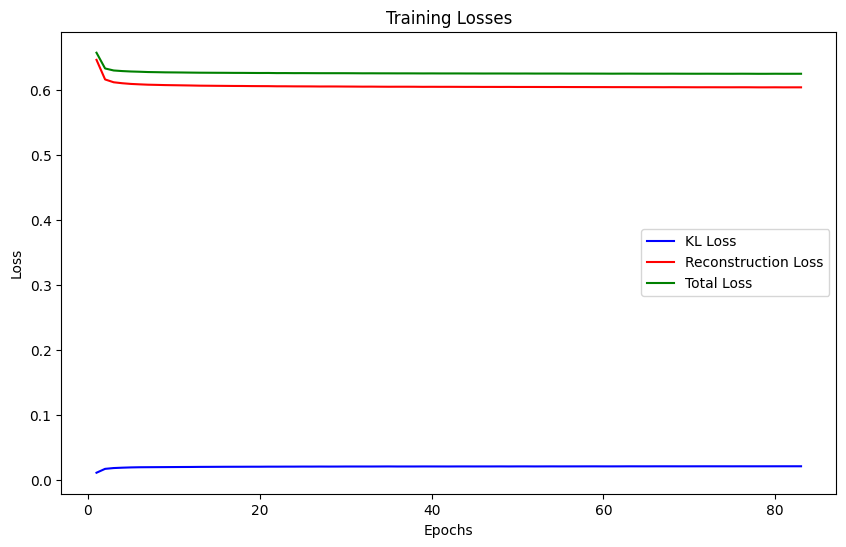

In [135]:
kl_loss = history.history['kl_loss']
reconstruction_loss = history.history['reconstruction_loss']
total_loss = history.history['loss']

# Plot the losses
epochs = range(1, len(kl_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, kl_loss, 'b', label='KL Loss')
plt.plot(epochs, reconstruction_loss, 'r', label='Reconstruction Loss')
plt.plot(epochs, total_loss, 'g', label='Total Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [136]:
num_images = 7

In [137]:
def generate_images_from_latent_vectors(vae, num_images_to_generate):
    # Generate random latent vectors
    random_latent_vectors = np.random.normal(size=(num_images_to_generate, latent_dim))

    # Decode the latent vectors to generate images
    generated_images = vae.decoder.predict(random_latent_vectors)

    return generated_images

# Generate images from random latent vectors
generated_images = generate_images_from_latent_vectors(vae, num_images)

1/1 [==============================] - 0s 79ms/step


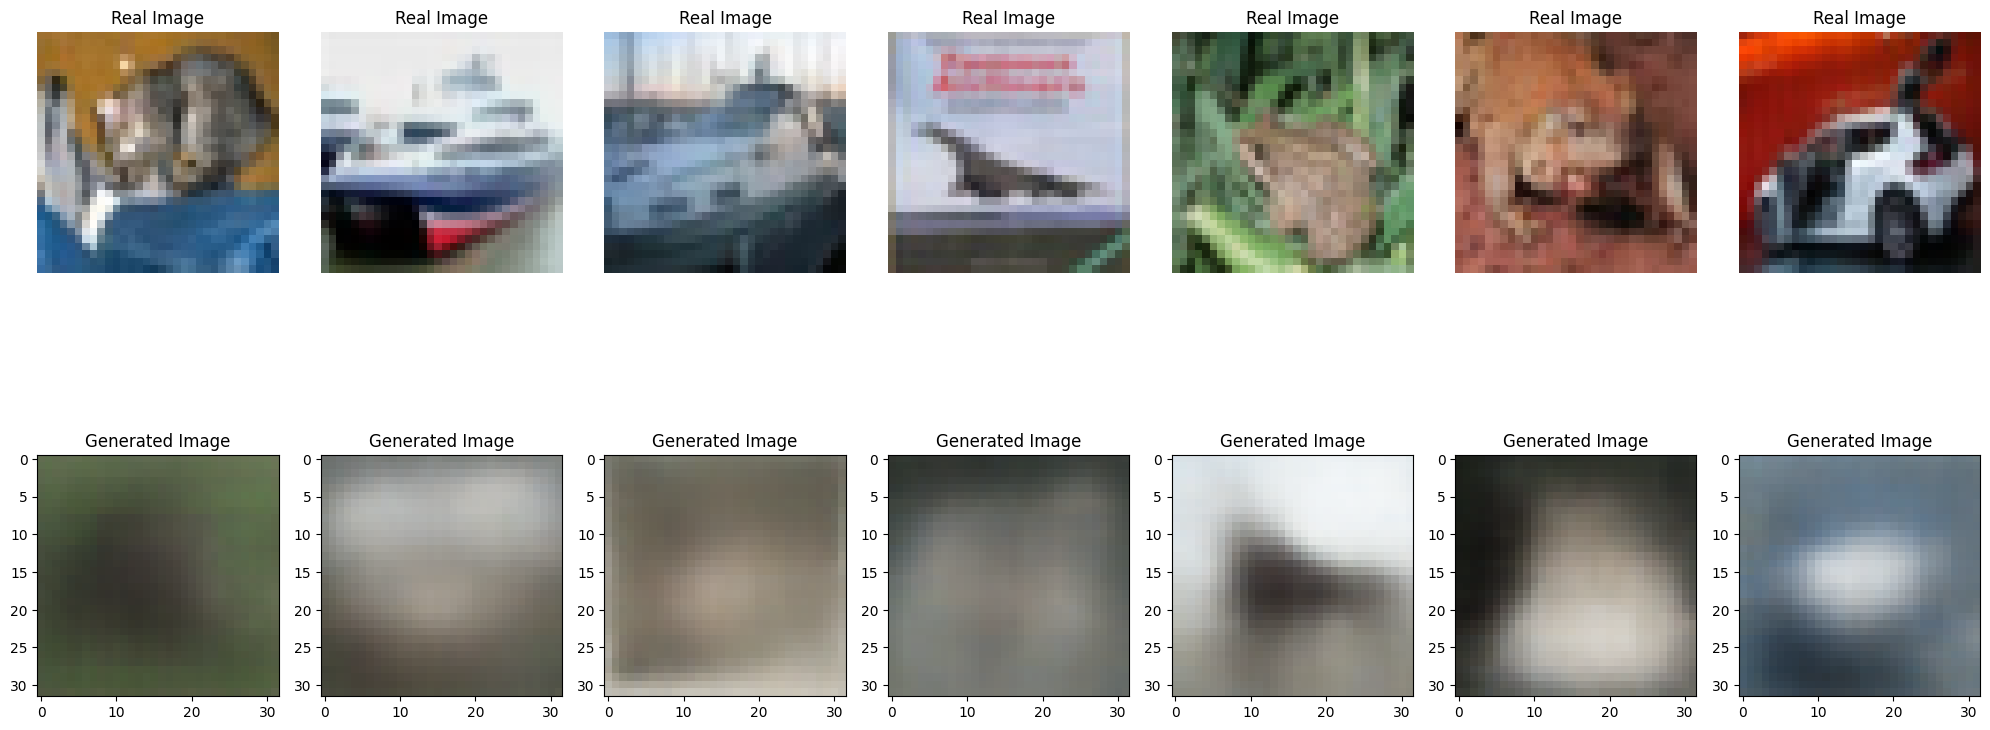

In [138]:
def plot_real_and_generated_images(real_images, generated_images, num_images_to_generate):
    plt.figure(figsize=(20, 10))

    # Plot real images
    for i in range(num_images_to_generate):
        plt.subplot(2, num_images_to_generate, i + 1)
        plt.imshow(real_images[i])
        plt.title('Real Image')
        plt.axis('off')

    # Plot generated images
    for i in range(num_images_to_generate):
        plt.subplot(2, num_images_to_generate, num_images_to_generate + i + 1)
        plt.imshow(generated_images[i])
        plt.title('Generated Image')
        # plt.axis('off')

    plt.tight_layout()
    plt.show()


# Plot real and generated images side by side vertically
plot_real_and_generated_images(x_test[:num_images], generated_images, num_images)


In [139]:
from tqdm import tqdm

def generate_latent_space(vae, n=20, scale=3):
    img_height = 32
    
    # Generate random latent vectors
    random_latent_vectors = np.random.normal(size=(n * n, latent_dim))

    generated_images = np.zeros((n * img_height, n * img_height, 3))

    for i, zi in enumerate(tqdm(np.linspace(-scale, scale, n), desc='Progress')):
        for j, zj in enumerate(np.linspace(-scale, scale, n)):
            z_sample = random_latent_vectors[i * n + j]
            # Suppress stdout temporarily
            with suppress_stdout():
                x_decoded = vae.decoder.predict(np.array([z_sample]))
            digit = x_decoded[0].reshape(img_height, img_height, 3)
            generated_images[
                i * img_height : (i + 1) * img_height,
                j * img_height : (j + 1) * img_height,
                :,
            ] = digit

    return generated_images

# Suppress stdout context manager
from contextlib import contextmanager
import os, sys

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

latent_space = generate_latent_space(vae)


Progress: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


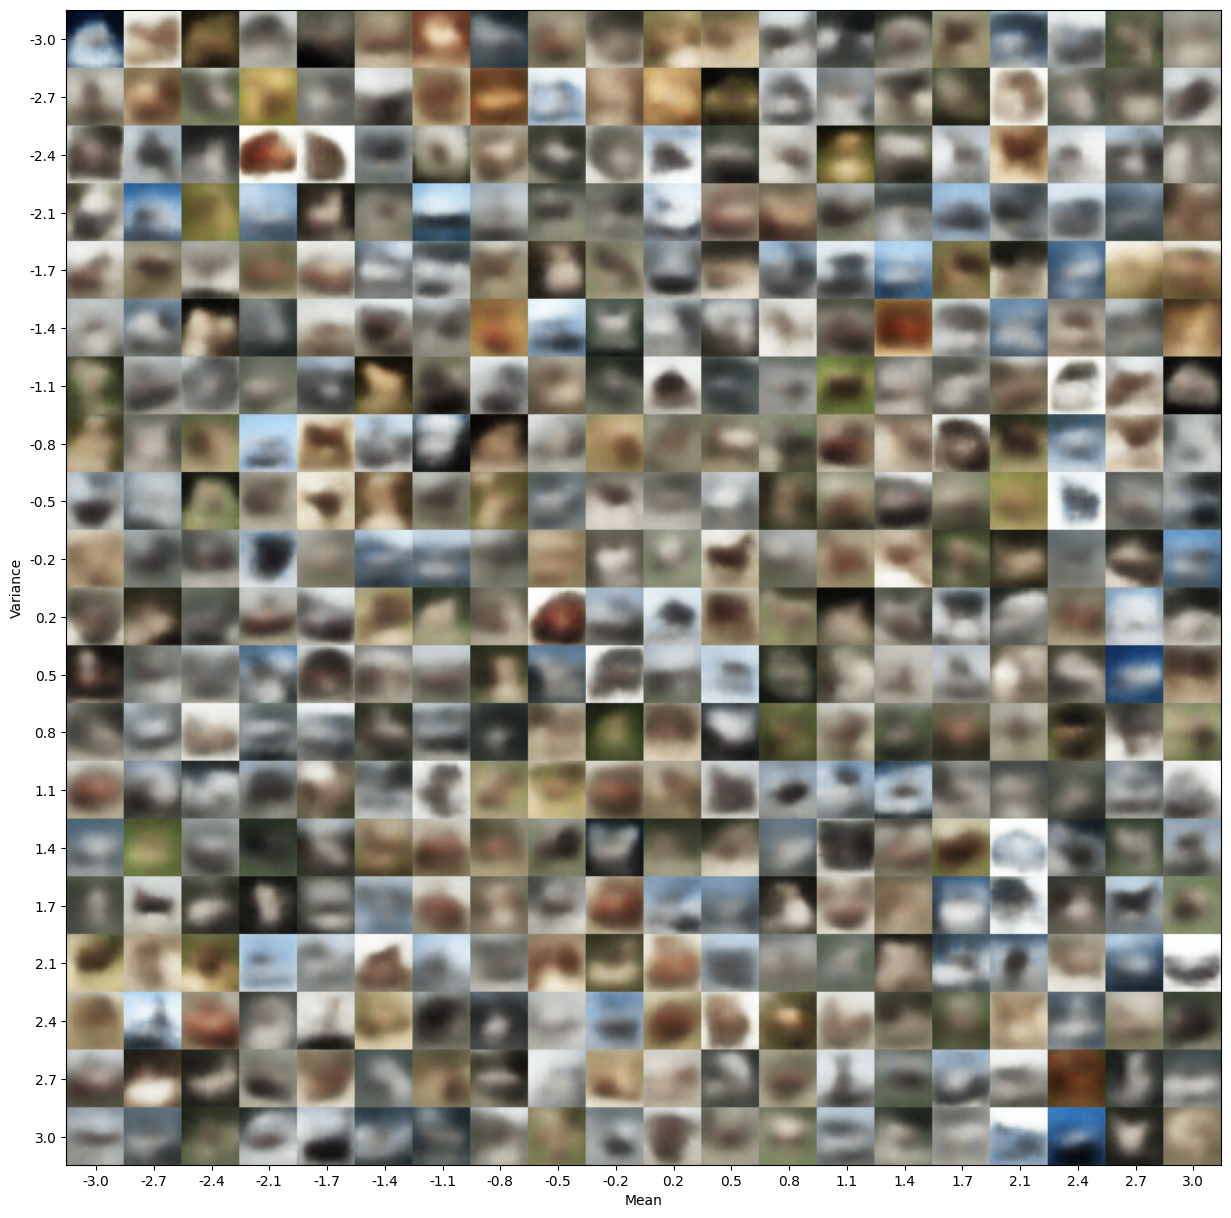

In [140]:
def plot_latent_space(generated_images, n=20, scale=3, figsize=15):
    img_height = generated_images.shape[0] // n
    
    plt.figure(figsize=(figsize, figsize))
    start_range = img_height // 2
    end_range = n * img_height + start_range
    pixel_range = np.arange(start_range, end_range, img_height)
    sample_range_x = np.round(np.linspace(-scale, scale, n), 1)
    sample_range_y = np.round(np.linspace(-scale, scale, n), 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("Mean")
    plt.ylabel("Variance")
    plt.imshow(generated_images)
    plt.show()
    
plot_latent_space(latent_space)